In [70]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [71]:
import cymetric as cym
from cymetric import graphs
from cymetric import timeseries
import sqlite3

In [72]:
import importlib.util

# Specify the path relative to the current notebook's directory
dep_spec = importlib.util.spec_from_file_location('deployment', '../scripts/deployment.py')
dep = importlib.util.module_from_spec(dep_spec)
dep_spec.loader.exec_module(dep)

tran_spec = importlib.util.spec_from_file_location('fuel_transactions', '../scripts/fuel_transactions.py')
tran = importlib.util.module_from_spec(tran_spec)
tran_spec.loader.exec_module(tran)

waste_spec = importlib.util.spec_from_file_location('waste', '../scripts/waste.py')
waste = importlib.util.module_from_spec(waste_spec)
waste_spec.loader.exec_module(waste)

In [73]:
file = 'base_recycle_out1.sqlite'

In [74]:
conn = sqlite3.connect(file)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

(b'\x8f\x9f\x9c\xc7\x00\xecL\x13\xbf\xa0P\xc5|n\xb2m', '', 2020, 1, 840, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


# Cymetric

In [75]:
db = cym.dbopen(file)
evaler = cym.Evaluator(db, write=False)

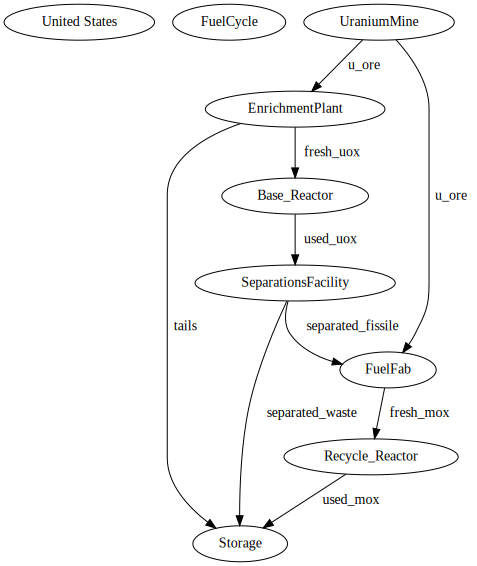

In [76]:
graphs.flow_graph(evaler, label='com')

In [77]:
reactor_list = ['Base_Reactor', 'Recycle_Reactor']
time = evaler.eval('TimeList')

Text(0, 0.5, 'Facilities [#]')

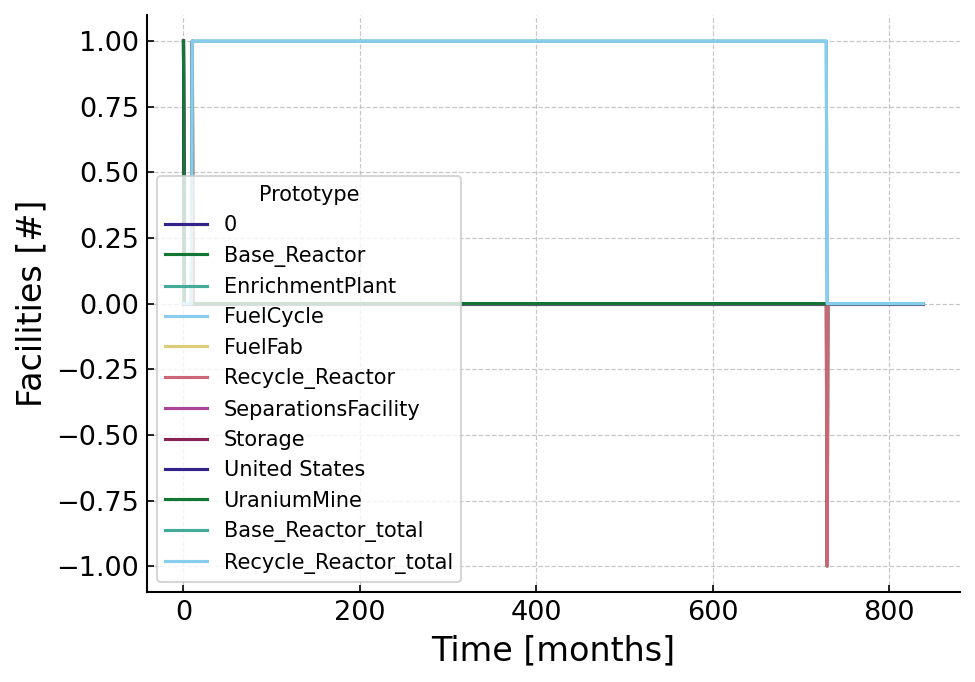

In [78]:
commission_by_prototype, commission_df = dep.comm_by_prototype(evaler, time)

decommission_by_prototype = dep.decom_by_prototype(evaler, commission_df, time)

deployment_by_prototype = dep.depl_by_prototype(commission_by_prototype, decommission_by_prototype, reactor_list)

deployment_by_prototype = dep.total_reactor(deployment_by_prototype, reactor_list)

deployment_by_prototype.plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Facilities [#]')

Text(0, 0.5, 'Reactors [#]')

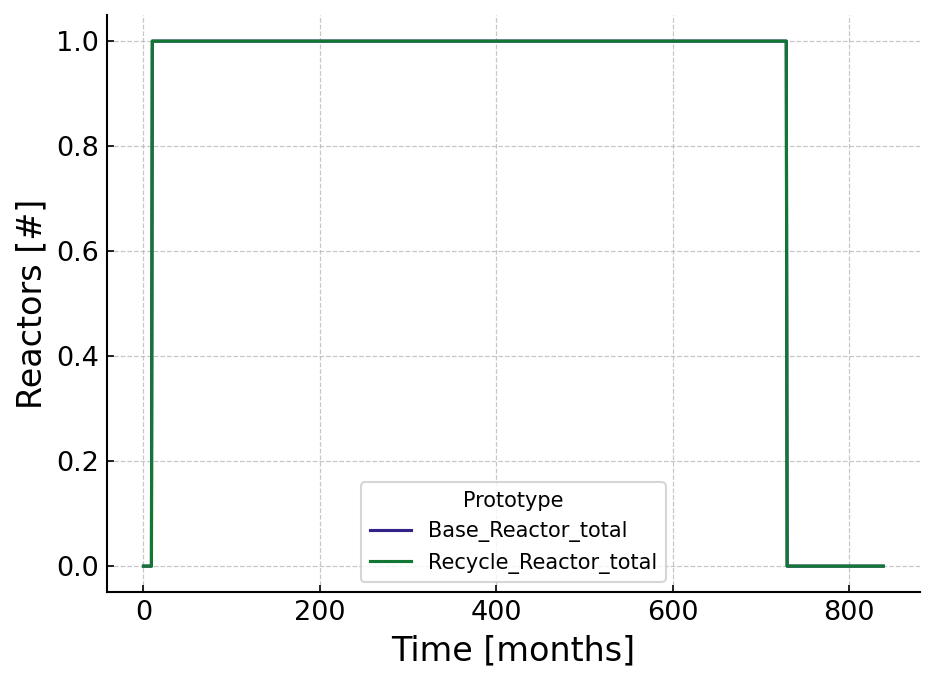

In [79]:
deployment_by_prototype[['Base_Reactor_total','Recycle_Reactor_total']].plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

In [80]:
repository_waste = timeseries.transactions(evaler=evaler, receivers=['Storage'])

Text(0, 0.5, 'Mass of waste [kg]')

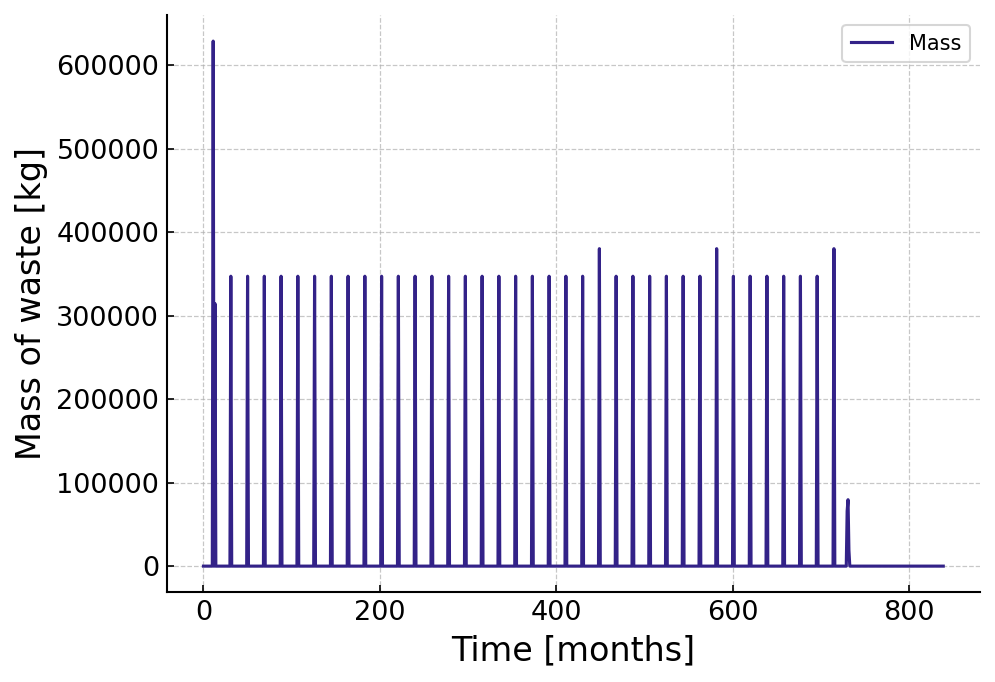

In [81]:
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

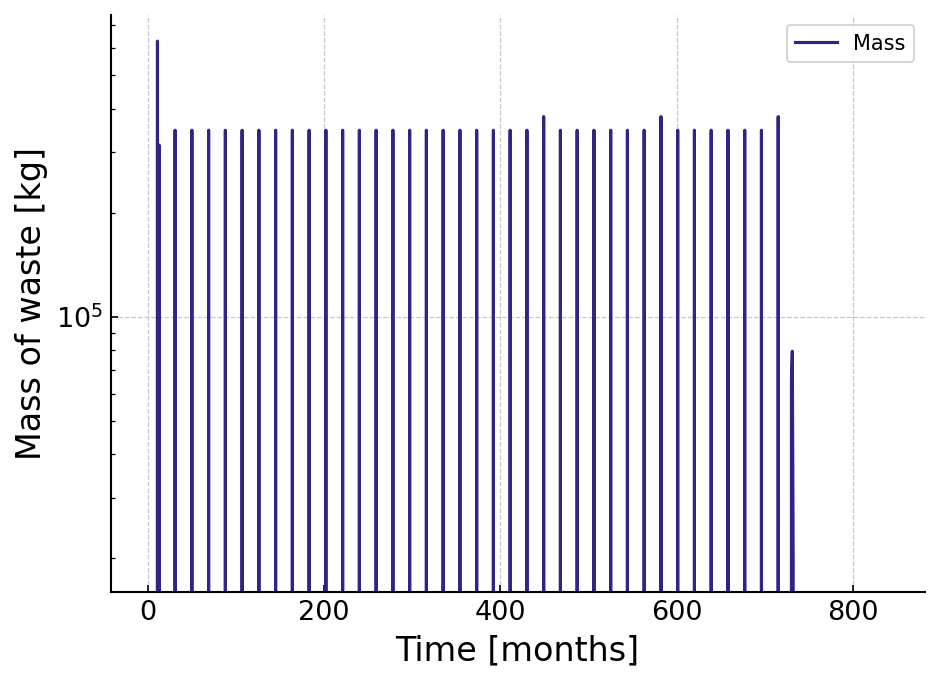

In [82]:
repository_waste.plot(x='Time', logy=True)
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

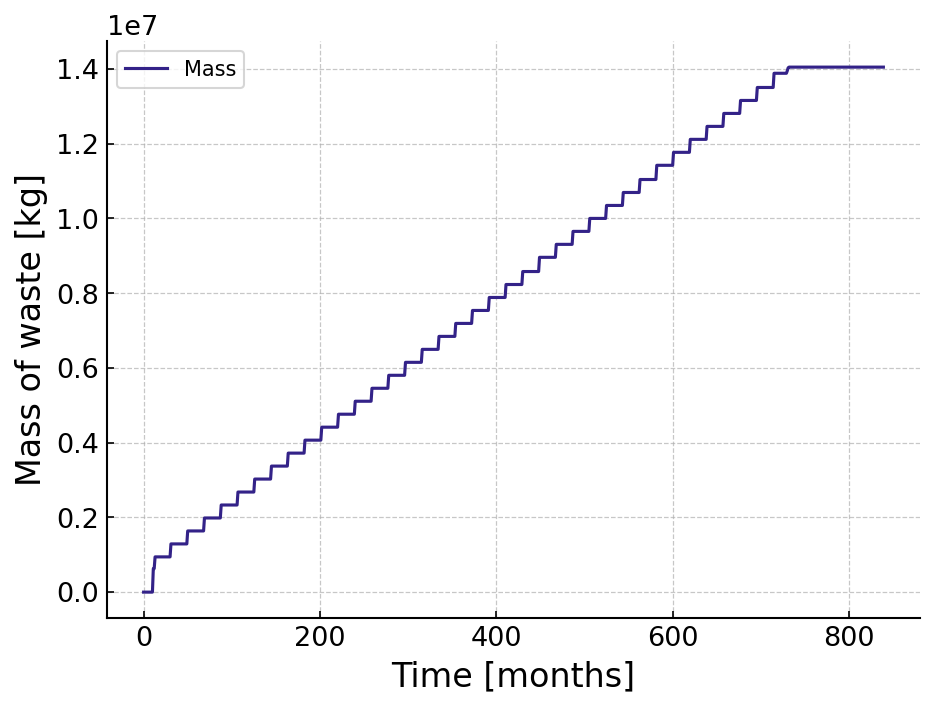

In [83]:
repository_waste['Mass'] = repository_waste['Mass'].cumsum()
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

In [84]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

fuels = ['uox','mox']

transactions = tran.used_fuel_transactions(transactions, fuels)
transactions = tran.fresh_fuel_transactions(transactions, fuels)
transactions = tran.total_used_fr_fuel(transactions, fuels)

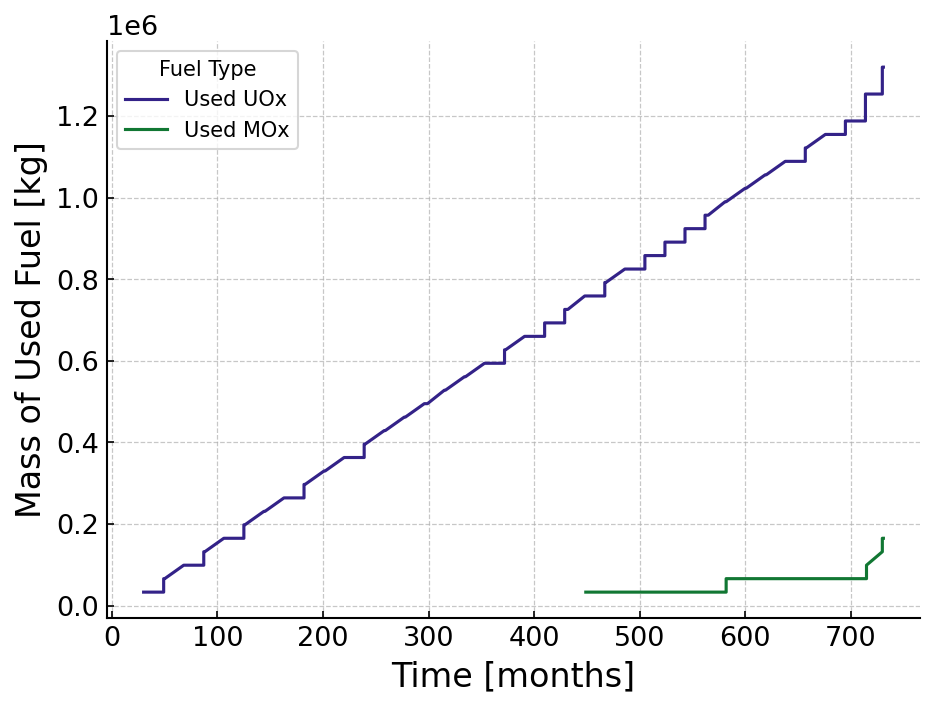

In [85]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'used_uox_total', 'used_mox_total']].plot(x = 'Time')
# , style=['-.','-']
plt.xlabel('Time [months]')
plt.ylabel('Mass of Used Fuel [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Used UOx')
legend.get_texts()[1].set_text('Used MOx')
legend.set_title('Fuel Type')

Text(0, 0.5, 'Mass of U235 [kg]')

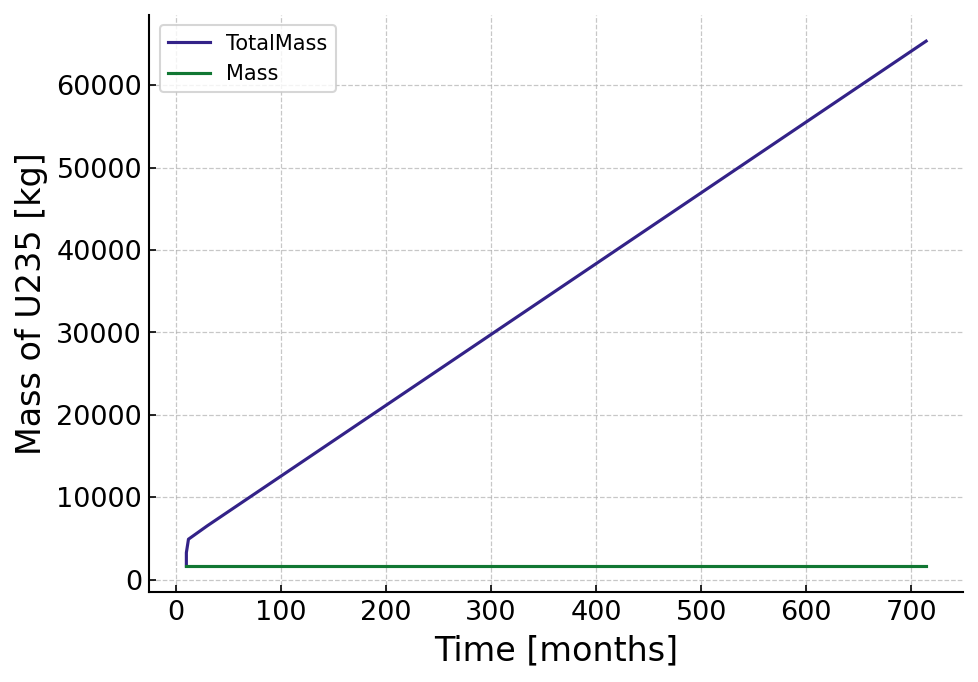

In [86]:
U235_mass = waste.transactions_nuc_built_in(evaler=evaler, receivers=['Base_Reactor'], commodities=['fresh_uox'], nucs=['92235'])

U235_mass['TotalMass'] = U235_mass['Mass'].cumsum()
U235_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

Text(0, 0.5, 'Mass of Pu239 [kg]')

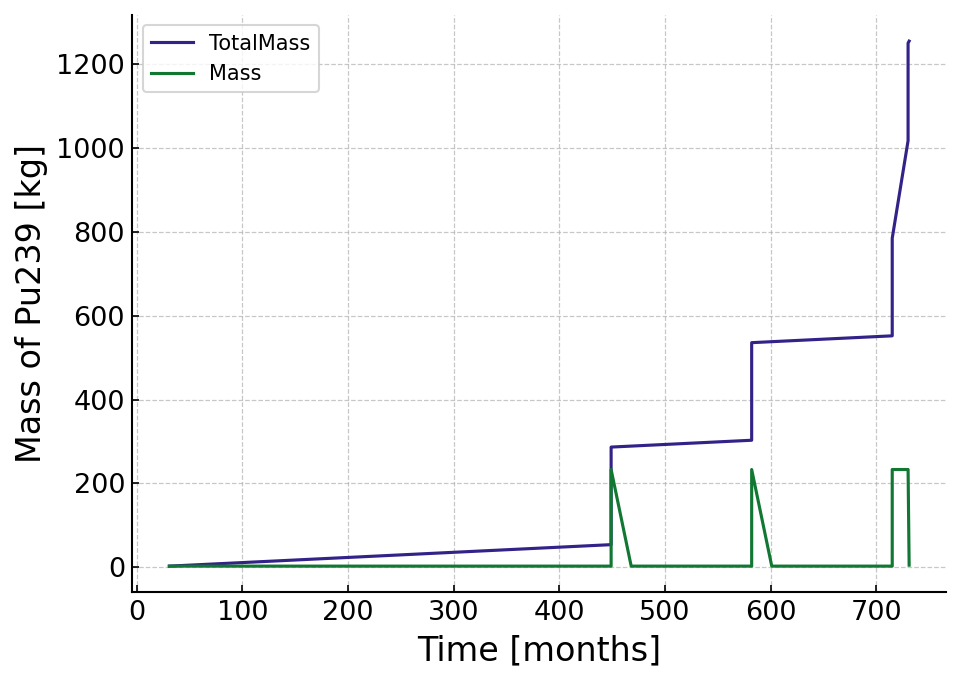

In [87]:
Pu239_mass = waste.transactions_nuc_built_in(evaler,receivers=['Storage'], commodities=['separated_waste','used_mox'], nucs=['94239'])

Pu239_mass['TotalMass'] = Pu239_mass['Mass'].cumsum()
Pu239_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of Pu239 [kg]')

Text(0, 0.5, 'Mass [kg]')

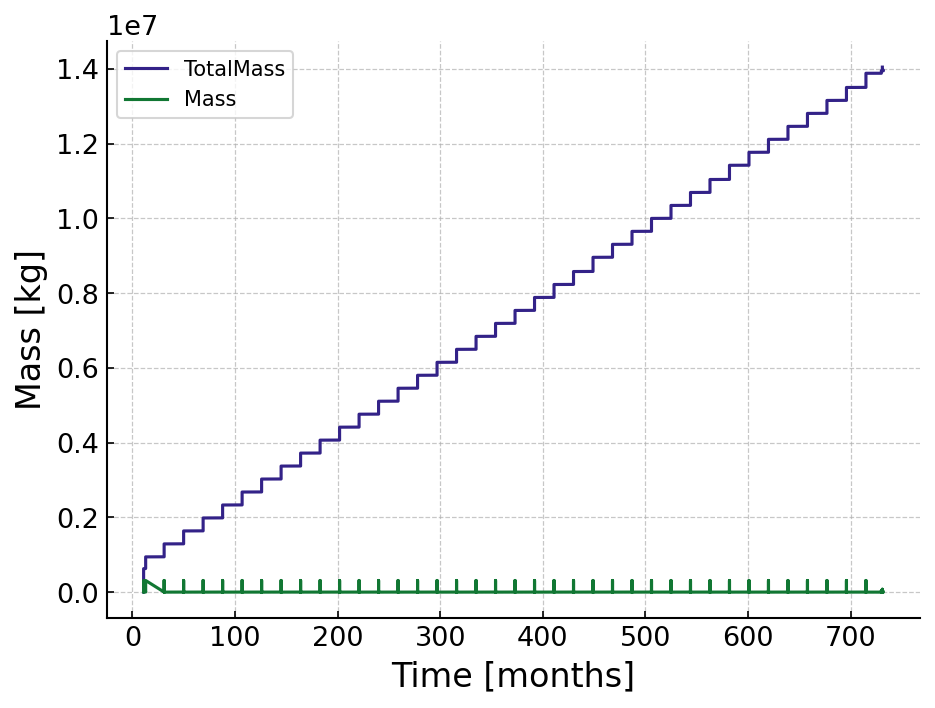

In [133]:
# waste classification isotopes
u_isotopes = [
    '922320000','922330000','922340000',
    '922350000','922360000','922380000']

np_isotopes = ['932370000']

pu_isotopes = [
    '942380000','942390000','942400000',
    '942410000','942420000','942440000'] # 94236 and 94244 not included

am_isotopes = ['952410000','952430000'] # 95242 not included

cm_isotopes = [
    '962440000','962430000','962460000',
    '962450000','962480000','962470000',
    '962350000','962370000'] # 96242 not included

all_isotopes = u_isotopes + np_isotopes + pu_isotopes + am_isotopes + cm_isotopes

mass_isotopes = waste.transactions_nuc_built_in(evaler,receivers=['Storage'], commodities=['separated_waste','used_mox','tails'], nucs=all_isotopes)

mass_isotopes['TotalMass'] = mass_isotopes['Mass'].cumsum()
mass_isotopes[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass [kg]')

In [142]:
times = np.arange(0,end_month)
d = {'Time':times}

# Create the dataframe and populate the columns for each isotope with zeros to
# start.
df_isotopes = pd.DataFrame(data=d)
for isotope in all_isotopes:
    df_isotopes[isotope] = 0
    df_isotopes[f'{isotope}_total'] = 0


# Track the mass of each isotope stored at each time.
for transaction in range(len(mass_isotopes)):
    for isotope in all_isotopes:
        if mass_isotopes.loc[transaction,'NucId'] == int(isotope):
            mass = mass_isotopes.loc[transaction,'Mass']
            time = mass_isotopes.loc[transaction,'Time']
            df_isotopes.loc[time,isotope] = mass

# Add up the totals for each isotope over time.
for isotope in all_isotopes:
    df_isotopes[f'{isotope}_total'] = df_isotopes[isotope].cumsum()

/tmp/ipykernel_32363/169100019.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1609.9354727169607' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_isotopes.loc[time,isotope] = mass
/tmp/ipykernel_32363/169100019.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '938.0516927063304' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_isotopes.loc[time,isotope] = mass
/tmp/ipykernel_32363/169100019.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '311745.84587607026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_isotopes.loc[time,isotope] = mass
/tmp/ipykernel_32363/169100019.py:18: FutureWarning: Setting a

In [143]:

df_isotopes


,Time,922320000,922320000_total,922330000,922330000_total,922340000,922340000_total,922350000,922350000_total,922360000,...,962450000,962450000_total,962480000,962480000_total,962470000,962470000_total,962350000,962350000_total,962370000,962370000_total
0,0,0.0,0.000000,0,0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0,0,0
1,1,0.0,0.000000,0,0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0,0,0
2,2,0.0,0.000000,0,0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0,0,0
3,3,0.0,0.000000,0,0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0,0,0
4,4,0.0,0.000000,0,0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,835,0.0,0.002778,0,0,0.0,3491.870491,0.0,14852.800074,0.0,...,0.0,18.434885,0.0,0.004011,0.0,0.045314,0,0,0,0
836,836,0.0,0.002778,0,0,0.0,3491.870491,0.0,14852.800074,0.0,...,0.0,18.434885,0.0,0.004011,0.0,0.045314,0,0,0,0
837,837,0.0,0.002778,0,0,0.0,3491.870491,0.0,14852.800074,0.0,...,0.0,18.434885,0.0,0.004011,0.0,0.045314,0,0,0,0
838,838,0.0,0.002778,0,0,0.0,3491.870491,0.0,14852.800074,0.0,...,0.0,18.434885,0.0,0.004011,0.0,0.045314,0,0,0,0


## Energy Production

In [ ]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

In [31]:
# we will pull the decom schedule to see the ids and decomission date, to id the reactor
cursor.execute("SELECT * FROM DecomSchedule")
decom_rows = cursor.fetchall()

for row in decom_rows:
    print(row)

(b'\x8f\x9f\x9c\xc7\x00\xecL\x13\xbf\xa0P\xc5|n\xb2m', 34, 730, 730)
(b'\x8f\x9f\x9c\xc7\x00\xecL\x13\xbf\xa0P\xc5|n\xb2m', 35, 730, 730)


In [32]:
# now we will pull the supplied power to get the amount of power from each reactor at every time step
cursor.execute("SELECT * FROM TimeSeriessupplyPOWER")
supply_rows = cursor.fetchall()

#for row in supply_rows:
#    print(row)

In [33]:
# create an empty dictionary that mirrors the format of the powersupply table
energy_supply = {
    'id':[],
    'time':[],
    'energy':[]
}

# now we will pull the power at each time step for each reactor
for row in range(len(supply_rows)):
    energy_supply['id'].append(str(supply_rows[row][1]))
    energy_supply['time'].append(supply_rows[row][2])
    energy_supply['energy'].append(supply_rows[row][3])

In [34]:
# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
energy_supply_df = pd.DataFrame.from_dict(energy_supply)

In [35]:
# we will turn the ids into columns of energy and make the index time
switch_energy_supply = energy_supply_df.pivot_table(index='time', columns='id', values='energy', fill_value=0)

# now we will add a total_energy column
switch_energy_supply['total_energy'] = switch_energy_supply.iloc[:,0:].sum(axis=1)

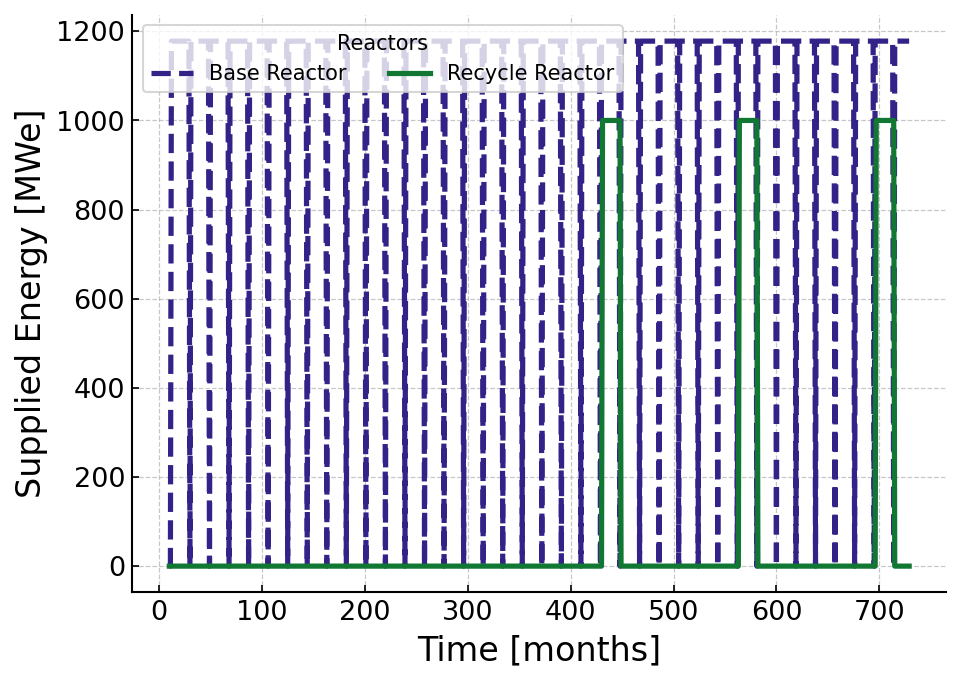

In [36]:
switch_energy_supply[['34','35']].plot(style=['--','-'], linewidth=2.5)
#switch_energy_supply[['53','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend(loc="upper left",ncol=3)
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Recycle Reactor')
legend.set_title('Reactors')

In [37]:
simulation_energy_supply = pd.DataFrame(index=range(start_month,end_month), columns=switch_energy_supply.columns)
simulation_energy_supply = simulation_energy_supply.fillna(0)

for column in switch_energy_supply.columns:
    for time in range(min(switch_energy_supply.index), max(switch_energy_supply.index)):
        simulation_energy_supply.loc[time, column] = switch_energy_supply.loc[time, column]

/tmp/ipykernel_11308/2997257727.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  simulation_energy_supply = simulation_energy_supply.fillna(0)


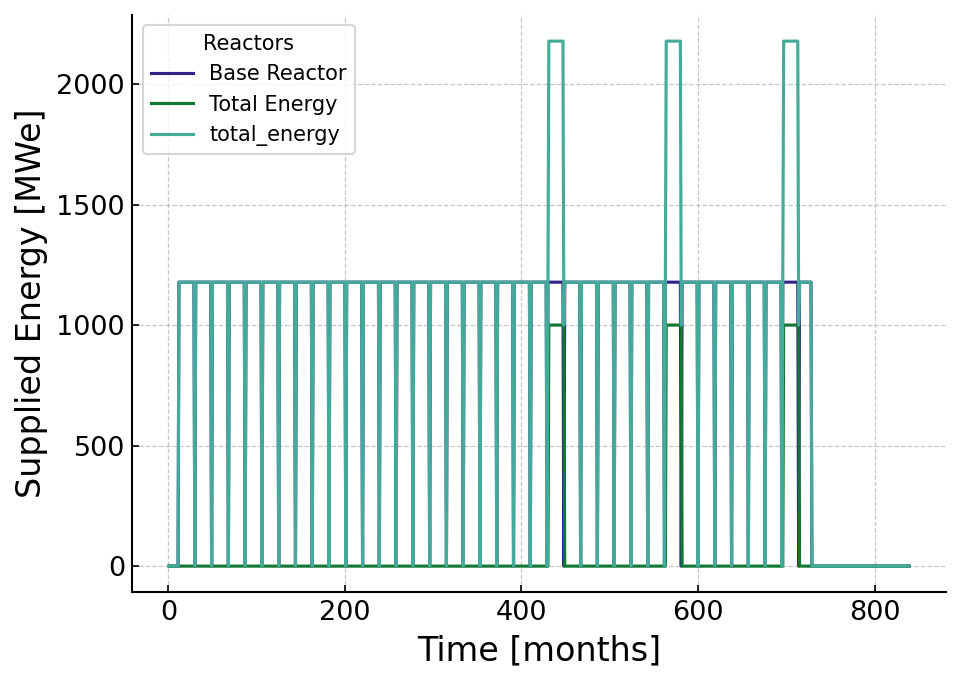

In [38]:
simulation_energy_supply.plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

## SWU

In [39]:
cursor.execute("SELECT * FROM TimeSeriesEnrichmentSWU")
swu_rows = cursor.fetchall()


# for row in swu_rows:
#    print(row)

In [40]:
# create an empty dictionary that mirrors the format of the TimeSeriesEnrichmentSWU table
swu_supply = {
    'id':[],
    'Time':[],
    'SWU':[]
}

# now we will pull the swu at each time step for each facility
for row in range(len(swu_rows)):
    swu_supply['id'].append(str(swu_rows[row][1]))
    swu_supply['Time'].append(swu_rows[row][2])
    swu_supply['SWU'].append(swu_rows[row][3])

# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
swu_supply_df = pd.DataFrame.from_dict(swu_supply)

In [41]:
# we will turn the ids into columns of energy and make the index time
switch_swu_supply = swu_supply_df.pivot_table(index='Time', columns='id', values='SWU', fill_value=0)

# now we will add a total_energy column
switch_swu_supply['total_swu'] = switch_swu_supply.iloc[:,0:].sum(axis=1)

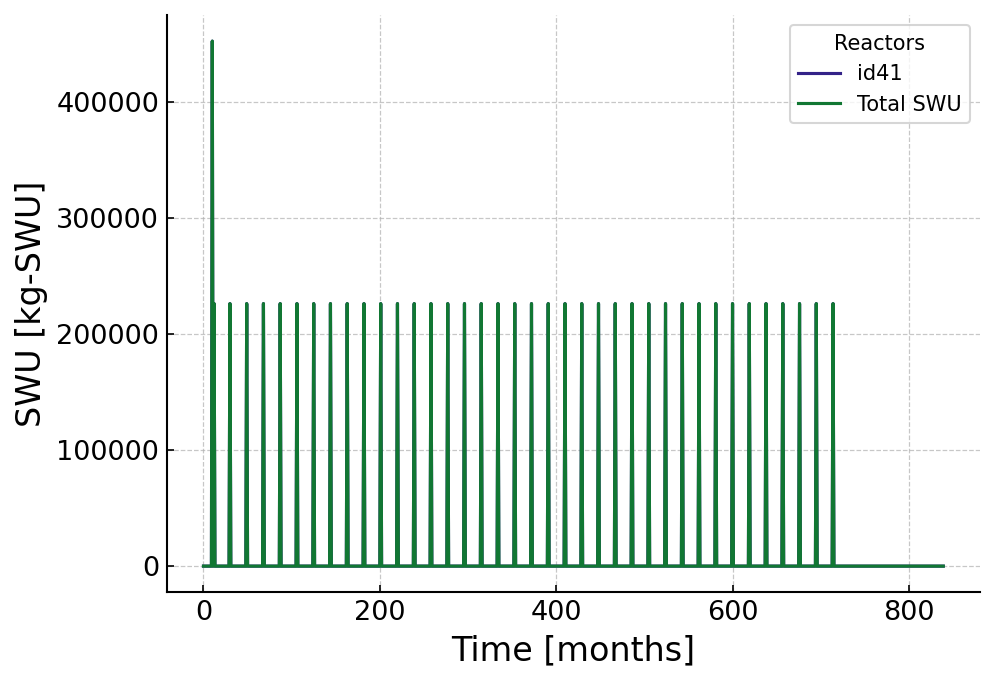

In [42]:
switch_swu_supply[['31','total_swu']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('id41')
legend.get_texts()[1].set_text('Total SWU')
legend.set_title('Reactors')